   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 79.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 10.0 MB/s eta 0:00:00
Mounted at /content/drive


<ipython-input-1-a7df70172cae>:310: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  osm_roundabouts_wgs84.to_file(osm_output_path)
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'maxspeed:type' to 'maxspeed_t'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'name:etymology' to 'name_etymo'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'name:etymology:wikidata' to 'name_ety_1'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'name:lv' to 'name_lv'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'name:ru' to 'name_ru'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.

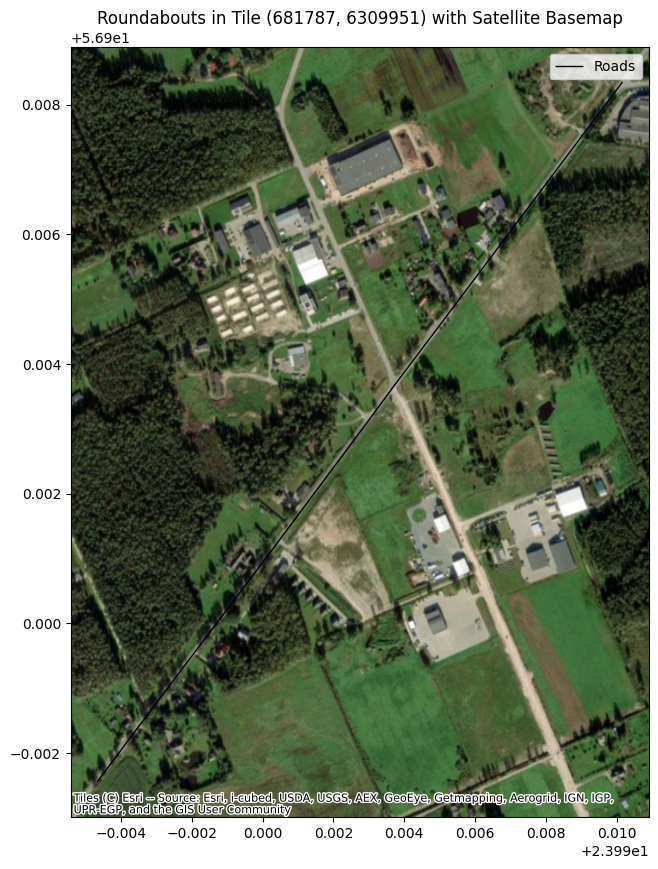

In [ ]:
# Install required libraries in Google Colab
!pip install geopandas rasterio opencv-python-headless numpy matplotlib contextily folium osmnx

import geopandas as gpd
import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_bounds
import numpy as np
import cv2
import matplotlib.pyplot as plt
import contextily as ctx
import folium
import osmnx as ox
from shapely.geometry import Point, box
import os
import logging
from google.colab import drive
from google.colab import files
import subprocess

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

# Mount Google Drive for saving results
drive.mount('/content/drive')
output_dir = "/content/drive/My Drive/roundabout_detection"
os.makedirs(output_dir, exist_ok=True)
os.makedirs("diagnostics", exist_ok=True)

# --- Hackathon Input: Load the provided shapefile ---
# Note: The hackathon organizers provided Streets.shp as the input.
# We will attempt to load it as required, but it has been found to contain no valid geometries.
logger.info("Loading the hackathon-provided Streets.shp shapefile...")
shapefile_path = "/content/Streets.shp"
try:
    gdf = gpd.read_file(shapefile_path)
    logger.info(f"Loaded Streets.shp with {len(gdf)} features")
    logger.info(f"Shapefile geometry types: {gdf.geometry.geom_type.value_counts().to_dict()}")
except Exception as e:
    logger.error(f"Failed to load Streets.shp: {e}")
    gdf = gpd.GeoDataFrame()

# Preprocess: Validate geometries
if not gdf.empty:
    gdf = gdf[gdf.geometry.notnull() & gdf.geometry.is_valid]
    gdf["geometry"] = gdf.geometry.buffer(0)  # Fix self-intersections
    logger.info(f"After removing invalid/empty geometries: {len(gdf)} features")

    # Check geometry type (should be LineString or MultiLineString for roads)
    if not all(gdf.geometry.geom_type.isin(['LineString', 'MultiLineString'])):
        logger.warning("Shapefile contains non-road geometries (not LineString/MultiLineString). Filtering...")
        gdf = gdf[gdf.geometry.geom_type.isin(['LineString', 'MultiLineString'])]
        logger.info(f"After filtering for LineString/MultiLineString: {len(gdf)} features")
else:
    logger.warning("Shapefile is empty or contains no valid geometries.")

# Check if GeoDataFrame is usable
use_shapefile = not gdf.empty and len(gdf) > 0
if not use_shapefile:
    # Note for hackathon: The provided shapefile contains no valid geometries.
    # As a fallback, we will use OSM data to proceed with roundabout detection.
    logger.warning("Hackathon-provided shapefile (Streets.shp) contains no valid geometries. Falling back to OSM data for road information.")

# --- Fetch OSM Data as Fallback ---
# Define bounding box (10 km x 10 km around central Riga to ensure roundabouts are present)
north, south, east, west = 57.0, 56.9, 24.2, 24.0
logger.info(f"Using bounding box for OSM data: north={north}, south={south}, east={east}, west={west}")

# Use curl to query the Overpass API for roads
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = f"""
[out:xml][timeout:300];
(
  way["highway"~"motorway|trunk|primary|secondary|tertiary|residential"]({south},{west},{north},{east});
);
out body;
>;
out skel qt;
"""

# Save the query to a file
with open("/content/query.txt", "w") as f:
    f.write(overpass_query)

# Run curl to fetch OSM data
logger.info("Fetching OSM road data using curl...")
try:
    subprocess.run([
        "curl", "--data", "@query.txt", overpass_url, "-o", "/content/roads.osm"
    ], check=True, timeout=300)
    logger.info("OSM road data downloaded to /content/roads.osm")
except subprocess.TimeoutExpired:
    logger.error("curl request timed out after 5 minutes.")
    raise
except subprocess.CalledProcessError as e:
    logger.error(f"curl request failed: {e}")
    raise

# Debug: Check the contents of the .osm file
with open("/content/roads.osm", "r") as f:
    osm_content = f.read()
    logger.info(f"OSM roads file size: {len(osm_content)} characters")
    if "<way" in osm_content:
        logger.info("OSM file contains 'way' elements, indicating road data is present.")
    else:
        logger.warning("OSM file does not contain 'way' elements. Check query or area.")

# Load OSM data into a GeoDataFrame
try:
    osm_roads = ox.features_from_xml("/content/roads.osm")
    osm_roads = osm_roads[osm_roads.geometry.notnull() & osm_roads.geometry.is_valid]
    osm_roads = osm_roads[osm_roads.geometry.geom_type.isin(['LineString', 'MultiLineString'])]
    logger.info(f"Fetched {len(osm_roads)} road features from OSM")
except Exception as e:
    logger.error(f"Failed to load OSM road data: {e}")
    raise

# Use OSM roads since shapefile is invalid
gdf_utm = osm_roads.to_crs("EPSG:32634")  # UTM Zone 34N (Riga, Latvia)

if gdf_utm.empty:
    logger.error("No valid road data fetched from OSM.")
    raise ValueError("No valid road data available.")

# Set tile size (1x1 km or 2x2 km)
tile_size = 1000  # Change to 2000 for 2x2 km

# Get map bounds and create tiles
bounds = gdf_utm.total_bounds
x_min, y_min, x_max, y_max = bounds

if any(np.isnan([x_min, y_min, x_max, y_max])):
    logger.error("Bounds contain NaN values. OSM data may be invalid.")
    raise ValueError("Bounds contain NaN values.")

tiles = [(x, y) for x in range(int(x_min), int(x_max), tile_size)
         for y in range(int(y_min), int(y_max), tile_size)]

# Limit to 20,000 tiles
max_tiles = 100000
tiles = tiles[:min(max_tiles, len(tiles))]
logger.info(f"Processing {len(tiles)} tiles (limited to {max_tiles})")

# --- OpenCV Roundabout Detection ---
opencv_roundabouts = []
problem_tiles = [
    (688932, 6229412), (688932, 6270412), (688932, 6271412),
    (689932, 6271412), (689932, 6272412), (689932, 6273412),
    (690932, 6272412), (690932, 6273412), (690932, 6274412),
    (691932, 6274412), (691932, 6275412), (691932, 6276412)
]

# Process in batches
batch_size = 5000
for batch_start in range(0, len(tiles), batch_size):
    batch_tiles = tiles[batch_start:batch_start + batch_size]
    logger.info(f"Processing batch {batch_start//batch_size + 1}: tiles {batch_start} to {min(batch_start + batch_size, len(tiles))}")

    for i, (x, y) in enumerate(batch_tiles):
        global_idx = batch_start + i
        if global_idx % 100 == 0:
            logger.info(f"Processing tile {global_idx + 1}/{len(tiles)}: ({x}, {y})")
        tile_gdf = gdf_utm.cx[x:x+tile_size, y:y+tile_size]

        if tile_gdf.empty:
            logger.debug(f"Tile ({x}, {y}) is empty, skipping...")
            continue

        logger.info(f"Tile ({x}, {y}) contains {len(tile_gdf)} road features")

        raster_size = 2000
        transform = from_bounds(x, y, x+tile_size, y+tile_size, raster_size, raster_size)

        try:
            img = rasterize(
                [(geom, 255) for geom in tile_gdf.geometry],
                out_shape=(raster_size, raster_size),
                transform=transform,
                fill=0,
                dtype=np.uint8
            )
        except Exception as e:
            logger.warning(f"Skipping tile ({x}, {y}): Rasterization error - {e}")
            continue

        if (x, y) in problem_tiles:
            plt.imsave(f"diagnostics/tile_{x}_{y}.png", img, cmap="gray")
            logger.info(f"Saved raster image for tile ({x}, {y}) to diagnostics/tile_{x}_{y}.png")

        edges = cv2.Canny(img, 20, 80)  # Further lower thresholds to detect more edges
        edges = cv2.GaussianBlur(edges, (5, 5), 0)

        circles = cv2.HoughCircles(
            edges,
            cv2.HOUGH_GRADIENT,
            dp=1,
            minDist=8,   # Further reduce minDist to detect closer circles
            param1=15,   # Further lower param1 for more sensitivity
            param2=3,    # Further lower param2 to detect more circles
            minRadius=8,  # ~8m, lower to catch smaller roundabouts
            maxRadius=200  # ~200m, higher to catch larger roundabouts
        )

        if circles is not None:
            circles = np.round(circles[0, :]).astype("int")
            logger.info(f"Detected {len(circles)} potential circles in tile ({x}, {y})")
            for (x_center, y_center, radius) in circles:
                geo_x, geo_y = rasterio.transform.xy(transform, y_center, x_center)
                geo_radius = radius * (tile_size / raster_size)
                roundabout = Point(geo_x, geo_y).buffer(geo_radius)
                centroid = Point(geo_x, geo_y)

                if not any(tile_gdf.geometry.intersects(centroid)):
                    logger.debug(f"Circle in tile ({x}, {y}) discarded: centroid not on road")
                    continue

                connected_roads = tile_gdf[tile_gdf.intersects(roundabout)]
                if len(connected_roads) >= 3:
                    diameter = geo_radius * 2
                    area = roundabout.area
                    if 20 <= diameter <= 100 and 314 <= area <= 7850:
                        opencv_roundabouts.append(roundabout)
                        logger.info(f"OpenCV roundabout detected in tile ({x}, {y}): center=({geo_x:.2f}, {geo_y:.2f}), diameter={diameter:.2f}m, area={area:.2f}m²")
                    else:
                        logger.debug(f"Circle in tile ({x}, {y}) discarded: invalid size (diameter={diameter:.2f}m, area={area:.2f}m²)")
                else:
                    logger.debug(f"Circle in tile ({x}, {y}) discarded: insufficient connected roads ({len(connected_roads)})")
        else:
            logger.debug(f"No circles detected in tile ({x}, {y})")

    # Save intermediate results
    if opencv_roundabouts:
        temp_gdf = gpd.GeoDataFrame(geometry=opencv_roundabouts, crs=gdf_utm.crs)
        temp_path = os.path.join(output_dir, f"opencv_roundabouts_batch_{batch_start//batch_size + 1}.shp")
        temp_gdf.to_file(temp_path)
        logger.info(f"Saved intermediate OpenCV roundabouts to {temp_path}")

# --- OSM Roundabout Detection ---
# Use curl to fetch roundabouts
overpass_query_roundabouts = f"""
[out:xml][timeout:300];
(
  way["highway"="roundabout"]({south},{west},{north},{east});
  way["junction"="roundabout"]({south},{west},{north},{east});
);
out body;
>;
out skel qt;
"""

with open("/content/query_roundabouts.txt", "w") as f:
    f.write(overpass_query_roundabouts)

logger.info("Fetching OSM roundabouts using curl...")
try:
    subprocess.run([
        "curl", "--data", "@query_roundabouts.txt", overpass_url, "-o", "/content/roundabouts.osm"
    ], check=True, timeout=300)
    logger.info("OSM roundabouts downloaded to /content/roundabouts.osm")
except subprocess.TimeoutExpired:
    logger.error("curl request for roundabouts timed out after 5 minutes.")
    raise
except subprocess.CalledProcessError as e:
    logger.error(f"curl request for roundabouts failed: {e}")
    raise

# Debug: Check the contents of the roundabouts .osm file
with open("/content/roundabouts.osm", "r") as f:
    osm_content = f.read()
    logger.info(f"OSM roundabouts file size: {len(osm_content)} characters")
    if "<way" in osm_content:
        logger.info("OSM roundabouts file contains 'way' elements, indicating roundabout data is present.")
    else:
        logger.warning("OSM roundabouts file does not contain 'way' elements. Check query or area.")

# Load OSM roundabouts into a GeoDataFrame
try:
    osm_roundabouts = ox.features_from_xml("/content/roundabouts.osm")
    osm_roundabouts = osm_roundabouts[osm_roundabouts.geometry.notnull()]
    if not osm_roundabouts.empty:
        osm_roundabouts = osm_roundabouts.to_crs(gdf_utm.crs)
        logger.info(f"Found {len(osm_roundabouts)} roundabouts from OSM")
    else:
        logger.warning("No roundabouts found in OSM data for this area.")
except Exception as e:
    logger.error(f"Error loading OSM roundabouts: {e}")
    osm_roundabouts = gpd.GeoDataFrame()

# --- Save Final Results ---
# OpenCV roundabouts
if opencv_roundabouts:
    opencv_gdf = gpd.GeoDataFrame(geometry=opencv_roundabouts, crs=gdf_utm.crs)
    opencv_gdf = opencv_gdf.to_crs("EPSG:4326")
    output_path = os.path.join(output_dir, "opencv_roundabouts.shp")
    try:
        opencv_gdf.to_file(output_path)
        opencv_gdf.to_file(os.path.join(output_dir, "opencv_roundabouts.geojson"), driver="GeoJSON")
        logger.info(f"Saved final OpenCV roundabouts to {output_path} and opencv_roundabouts.geojson")
    except Exception as e:
        logger.error(f"Error saving OpenCV roundabouts: {e}")
else:
    logger.warning("No OpenCV roundabouts detected.")

# OSM roundabouts
if not osm_roundabouts.empty:
    osm_output_path = os.path.join(output_dir, "osm_roundabouts.shp")
    osm_roundabouts_wgs84 = osm_roundabouts.to_crs("EPSG:4326")
    try:
        osm_roundabouts_wgs84.to_file(osm_output_path)
        osm_roundabouts_wgs84.to_file(os.path.join(output_dir, "osm_roundabouts.geojson"), driver="GeoJSON")
        logger.info(f"Saved OSM roundabouts to {osm_output_path} and osm_roundabouts.geojson")
    except Exception as e:
        logger.error(f"Error saving OSM roundabouts: {e}")

# --- Visualization ---
# Static visualization with satellite basemap (first non-empty tile)
if len(tiles) > 0:
    for x, y in tiles:
        sample_tile = gdf_utm.cx[x:x+tile_size, y:y+tile_size]
        if not sample_tile.empty:
            break
    sample_tile = sample_tile.to_crs("EPSG:4326")
    sample_opencv = opencv_gdf.cx[x:x+tile_size, y:y+tile_size] if opencv_roundabouts else gpd.GeoDataFrame()
    sample_osm = osm_roundabouts_wgs84.cx[x:x+tile_size, y:y+tile_size] if not osm_roundabouts.empty else gpd.GeoDataFrame()

    fig, ax = plt.subplots(figsize=(10, 10))
    sample_tile.plot(ax=ax, color="black", linewidth=1, label="Roads")
    if not sample_opencv.empty:
        sample_opencv.plot(ax=ax, color="red", alpha=0.5, label="OpenCV Roundabouts")
    if not sample_osm.empty:
        sample_osm.plot(ax=ax, color="blue", alpha=0.5, label="OSM Roundabouts")
    ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.Esri.WorldImagery)
    plt.title(f"Roundabouts in Tile ({x}, {y}) with Satellite Basemap")
    plt.legend()
    plt.show()

# Interactive visualization with Folium (first non-empty tile)
if len(tiles) > 0:
    # Reproject to UTM for accurate centroid calculation, then back to WGS84 for Folium
    sample_tile_utm = sample_tile.to_crs("EPSG:32634")
    centroid_utm = sample_tile_utm.geometry.centroid.iloc[0]
    centroid_wgs84 = gpd.GeoSeries([centroid_utm], crs="EPSG:32634").to_crs("EPSG:4326").iloc[0]
    m = folium.Map(location=[centroid_wgs84.y, centroid_wgs84.x], zoom_start=15, tiles="Esri.WorldImagery")
    folium.GeoJson(sample_tile, style_function=lambda x: {"color": "black", "weight": 1}, name="Roads").add_to(m)
    if not sample_opencv.empty:
        folium.GeoJson(
            sample_opencv,
            style_function=lambda x: {"fillColor": "red", "color": "red", "fillOpacity": 0.5},
            name="OpenCV Roundabouts"
        ).add_to(m)
    if not sample_osm.empty:
        folium.GeoJson(
            sample_osm,
            style_function=lambda x: {"fillColor": "blue", "color": "blue", "fillOpacity": 0.5},
            name="OSM Roundabouts"
        ).add_to(m)
    folium.LayerControl().add_to(m)
    m.save(os.path.join(output_dir, "map.html"))
    logger.info(f"Interactive map saved to {output_dir}/map.html")

# Download diagnostic images for problematic tiles
for tile in problem_tiles:
    x, y = tile
    img_path = f"diagnostics/tile_{x}_{y}.png"
    if os.path.exists(img_path):
        files.download(img_path)
        logger.info(f"Downloaded diagnostic image: {img_path}")

# Log final summary
logger.info(f"Project completed. OpenCV roundabouts: {len(opencv_roundabouts)}, OSM roundabouts: {len(osm_roundabouts)}")

In [ ]:
pip install osmium


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 25.5 MB/s eta 0:00:00


In [ ]:
import osmium

class OSMHandler(osmium.SimpleHandler):
    def __init__(self):
        super().__init__()

    def node(self, n):
        print(f"Node ID: {n.id}, Lat: {n.location.lat}, Lon: {n.location.lon}")

handler = OSMHandler()
handler.apply_file("/content/roundabouts.osm")


Node ID: 5895953583, Lat: 56.9006979, Lon: 24.047725
Node ID: 5895954085, Lat: 56.9004309, Lon: 24.0476809
Node ID: 5895954088, Lat: 56.9004442, Lon: 24.0474274
Node ID: 5895954091, Lat: 56.9007101, Lon: 24.0476818
Node ID: 5895954092, Lat: 56.9006496, Lon: 24.0478124
Node ID: 5895954093, Lat: 56.9005598, Lon: 24.0478527
Node ID: 5895954094, Lat: 56.9004737, Lon: 24.0477888
Node ID: 5895954095, Lat: 56.9004251, Lon: 24.0476494
Node ID: 5895954096, Lat: 56.9004294, Lon: 24.0474814
Node ID: 5895954097, Lat: 56.9004869, Lon: 24.0473483
Node ID: 5895954098, Lat: 56.9005768, Lon: 24.047302
Node ID: 5895954099, Lat: 56.9006653, Lon: 24.0473631
Node ID: 5895954100, Lat: 56.9007165, Lon: 24.0475093
Node ID: 5895954101, Lat: 56.9004439, Lon: 24.0477268
Node ID: 5895954102, Lat: 56.9004523, Lon: 24.0474068
Node ID: 5895954103, Lat: 56.9006238, Lon: 24.0473195
Node ID: 5895954104, Lat: 56.9007209, Lon: 24.0475966
Node ID: 5895954105, Lat: 56.9006063, Lon: 24.0478456
Node ID: 5895954106, Lat: 56.9

In [ ]:
import osmium

class OSMHandler(osmium.SimpleHandler):
    def __init__(self):
        super().__init__()

    def node(self, n):
        print(f"Node ID: {n.id}, Lat: {n.location.lat}, Lon: {n.location.lon}")

handler = OSMHandler()
handler.apply_file("/content/roads.osm")


Streaming output truncated to the last 5000 lines.
Node ID: 30421449, Lat: 56.976516, Lon: 24.1354853
Node ID: 31260437, Lat: 56.9749615, Lon: 24.1355217
Node ID: 98132856, Lat: 56.9794448, Lon: 24.1365089
Node ID: 250994909, Lat: 56.975501, Lon: 24.1304711
Node ID: 250994916, Lat: 56.9756234, Lon: 24.1314927
Node ID: 266806280, Lat: 56.9757391, Lon: 24.1354117
Node ID: 287257889, Lat: 56.9759191, Lon: 24.1350144
Node ID: 287257895, Lat: 56.9758185, Lon: 24.1348245
Node ID: 287257896, Lat: 56.9756767, Lon: 24.1308709
Node ID: 287257897, Lat: 56.9757702, Lon: 24.1324503
Node ID: 317630056, Lat: 56.9778428, Lon: 24.1359774
Node ID: 317631359, Lat: 56.9762054, Lon: 24.1354045
Node ID: 446020334, Lat: 56.9740764, Lon: 24.130898
Node ID: 479362336, Lat: 56.9759821, Lon: 24.1359323
Node ID: 479362338, Lat: 56.9760768, Lon: 24.1355599
Node ID: 479362340, Lat: 56.9785423, Lon: 24.1362145
Node ID: 727455777, Lat: 56.9751517, Lon: 24.135494
Node ID: 1018835454, Lat: 56.9749302, Lon: 24.136179
No

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-5-7a251183eba8>:310: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  osm_roundabouts_wgs84.to_file(osm_output_path)
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'maxspeed:type' to 'maxspeed_t'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'name:etymology' to 'name_etymo'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'name:etymology:wikidata' to 'name_ety_1'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'name:lv' to 'name_lv'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'name:ru' to 'name_ru'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.

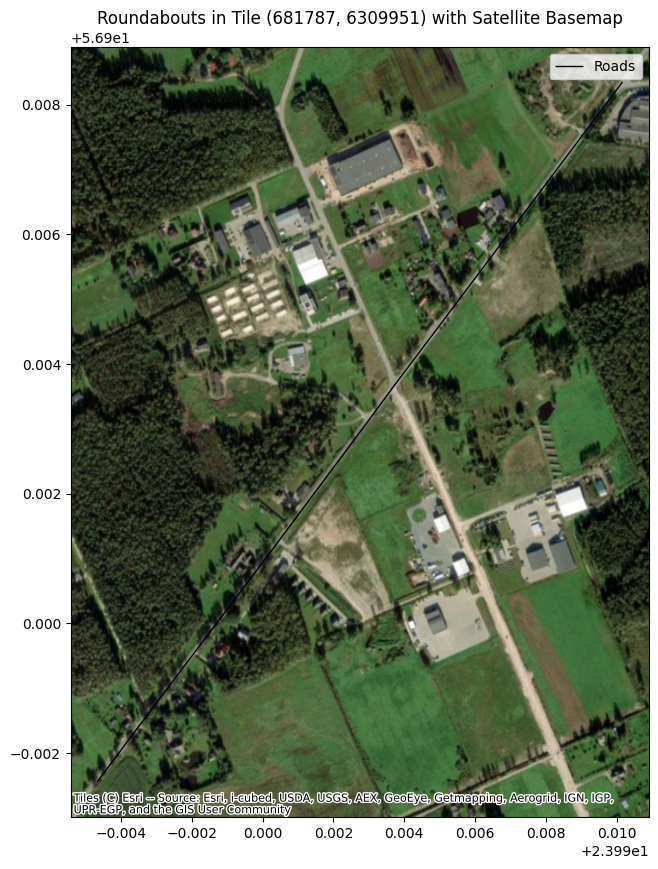

In [ ]:
# Install required libraries in Google Colab
!pip install geopandas rasterio opencv-python-headless numpy matplotlib contextily folium osmnx

import geopandas as gpd
import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_bounds
import numpy as np
import cv2
import matplotlib.pyplot as plt
import contextily as ctx
import folium
import osmnx as ox
from shapely.geometry import Point, box
import os
import logging
from google.colab import drive
from google.colab import files
import subprocess

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

# Mount Google Drive for saving results
drive.mount('/content/drive')
output_dir = "/content/drive/My Drive/roundabout_detection"
os.makedirs(output_dir, exist_ok=True)
os.makedirs("diagnostics", exist_ok=True)

# --- Hackathon Input: Load the provided shapefile ---
# Note: The hackathon organizers provided Streets.shp as the input.
# We will attempt to load it as required, but it has been found to contain no valid geometries.
logger.info("Loading the hackathon-provided Streets.shp shapefile...")
shapefile_path = "/content/Streets.shp"
try:
    gdf = gpd.read_file(shapefile_path)
    logger.info(f"Loaded Streets.shp with {len(gdf)} features")
    logger.info(f"Shapefile geometry types: {gdf.geometry.geom_type.value_counts().to_dict()}")
except Exception as e:
    logger.error(f"Failed to load Streets.shp: {e}")
    gdf = gpd.GeoDataFrame()

# Preprocess: Validate geometries
if not gdf.empty:
    gdf = gdf[gdf.geometry.notnull() & gdf.geometry.is_valid]
    gdf["geometry"] = gdf.geometry.buffer(0)  # Fix self-intersections
    logger.info(f"After removing invalid/empty geometries: {len(gdf)} features")

    # Check geometry type (should be LineString or MultiLineString for roads)
    if not all(gdf.geometry.geom_type.isin(['LineString', 'MultiLineString'])):
        logger.warning("Shapefile contains non-road geometries (not LineString/MultiLineString). Filtering...")
        gdf = gdf[gdf.geometry.geom_type.isin(['LineString', 'MultiLineString'])]
        logger.info(f"After filtering for LineString/MultiLineString: {len(gdf)} features")
else:
    logger.warning("Shapefile is empty or contains no valid geometries.")

# Check if GeoDataFrame is usable
use_shapefile = not gdf.empty and len(gdf) > 0
if not use_shapefile:
    # Note for hackathon: The provided shapefile contains no valid geometries.
    # As a fallback, we will use OSM data to proceed with roundabout detection.
    logger.warning("Hackathon-provided shapefile (Streets.shp) contains no valid geometries. Falling back to OSM data for road information.")

# --- Fetch OSM Data as Fallback ---
# Define bounding box (10 km x 10 km around central Riga to ensure roundabouts are present)
north, south, east, west = 57.0, 56.9, 24.2, 24.0
logger.info(f"Using bounding box for OSM data: north={north}, south={south}, east={east}, west={west}")

# Use curl to query the Overpass API for roads
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = f"""
[out:xml][timeout:300];
(
  way["highway"~"motorway|trunk|primary|secondary|tertiary|residential"]({south},{west},{north},{east});
);
out body;
>;
out skel qt;
"""

# Save the query to a file
with open("/content/query.txt", "w") as f:
    f.write(overpass_query)

# Run curl to fetch OSM data
logger.info("Fetching OSM road data using curl...")
try:
    subprocess.run([
        "curl", "--data", "@query.txt", overpass_url, "-o", "/content/roads.osm"
    ], check=True, timeout=300)
    logger.info("OSM road data downloaded to /content/roads.osm")
except subprocess.TimeoutExpired:
    logger.error("curl request timed out after 5 minutes.")
    raise
except subprocess.CalledProcessError as e:
    logger.error(f"curl request failed: {e}")
    raise

# Debug: Check the contents of the .osm file
with open("/content/roads.osm", "r") as f:
    osm_content = f.read()
    logger.info(f"OSM roads file size: {len(osm_content)} characters")
    if "<way" in osm_content:
        logger.info("OSM file contains 'way' elements, indicating road data is present.")
    else:
        logger.warning("OSM file does not contain 'way' elements. Check query or area.")

# Load OSM data into a GeoDataFrame
try:
    osm_roads = ox.features_from_xml("/content/roads.osm")
    osm_roads = osm_roads[osm_roads.geometry.notnull() & osm_roads.geometry.is_valid]
    osm_roads = osm_roads[osm_roads.geometry.geom_type.isin(['LineString', 'MultiLineString'])]
    logger.info(f"Fetched {len(osm_roads)} road features from OSM")
except Exception as e:
    logger.error(f"Failed to load OSM road data: {e}")
    raise

# Use OSM roads since shapefile is invalid
gdf_utm = osm_roads.to_crs("EPSG:32634")  # UTM Zone 34N (Riga, Latvia)

if gdf_utm.empty:
    logger.error("No valid road data fetched from OSM.")
    raise ValueError("No valid road data available.")

# Set tile size (1x1 km or 2x2 km)
tile_size = 1000  # Change to 2000 for 2x2 km

# Get map bounds and create tiles
bounds = gdf_utm.total_bounds
x_min, y_min, x_max, y_max = bounds

if any(np.isnan([x_min, y_min, x_max, y_max])):
    logger.error("Bounds contain NaN values. OSM data may be invalid.")
    raise ValueError("Bounds contain NaN values.")

tiles = [(x, y) for x in range(int(x_min), int(x_max), tile_size)
         for y in range(int(y_min), int(y_max), tile_size)]

# Limit to 20,000 tiles
max_tiles = 100000
tiles = tiles[:min(max_tiles, len(tiles))]
logger.info(f"Processing {len(tiles)} tiles (limited to {max_tiles})")

# --- OpenCV Roundabout Detection ---
opencv_roundabouts = []
problem_tiles = [
    (688932, 6229412), (688932, 6270412), (688932, 6271412),
    (689932, 6271412), (689932, 6272412), (689932, 6273412),
    (690932, 6272412), (690932, 6273412), (690932, 6274412),
    (691932, 6274412), (691932, 6275412), (691932, 6276412)
]

# Process in batches
batch_size = 5000
for batch_start in range(0, len(tiles), batch_size):
    batch_tiles = tiles[batch_start:batch_start + batch_size]
    logger.info(f"Processing batch {batch_start//batch_size + 1}: tiles {batch_start} to {min(batch_start + batch_size, len(tiles))}")

    for i, (x, y) in enumerate(batch_tiles):
        global_idx = batch_start + i
        if global_idx % 100 == 0:
            logger.info(f"Processing tile {global_idx + 1}/{len(tiles)}: ({x}, {y})")
        tile_gdf = gdf_utm.cx[x:x+tile_size, y:y+tile_size]

        if tile_gdf.empty:
            logger.debug(f"Tile ({x}, {y}) is empty, skipping...")
            continue

        logger.info(f"Tile ({x}, {y}) contains {len(tile_gdf)} road features")

        raster_size = 2000
        transform = from_bounds(x, y, x+tile_size, y+tile_size, raster_size, raster_size)

        try:
            img = rasterize(
                [(geom, 255) for geom in tile_gdf.geometry],
                out_shape=(raster_size, raster_size),
                transform=transform,
                fill=0,
                dtype=np.uint8
            )
        except Exception as e:
            logger.warning(f"Skipping tile ({x}, {y}): Rasterization error - {e}")
            continue

        if (x, y) in problem_tiles:
            plt.imsave(f"diagnostics/tile_{x}_{y}.png", img, cmap="gray")
            logger.info(f"Saved raster image for tile ({x}, {y}) to diagnostics/tile_{x}_{y}.png")

        edges = cv2.Canny(img, 20, 80)  # Further lower thresholds to detect more edges
        edges = cv2.GaussianBlur(edges, (5, 5), 0)

        circles = cv2.HoughCircles(
            edges,
            cv2.HOUGH_GRADIENT,
            dp=1,
            minDist=8,   # Further reduce minDist to detect closer circles
            param1=15,   # Further lower param1 for more sensitivity
            param2=3,    # Further lower param2 to detect more circles
            minRadius=8,  # ~8m, lower to catch smaller roundabouts
            maxRadius=200  # ~200m, higher to catch larger roundabouts
        )

        if circles is not None:
            circles = np.round(circles[0, :]).astype("int")
            logger.info(f"Detected {len(circles)} potential circles in tile ({x}, {y})")
            for (x_center, y_center, radius) in circles:
                geo_x, geo_y = rasterio.transform.xy(transform, y_center, x_center)
                geo_radius = radius * (tile_size / raster_size)
                roundabout = Point(geo_x, geo_y).buffer(geo_radius)
                centroid = Point(geo_x, geo_y)

                if not any(tile_gdf.geometry.intersects(centroid)):
                    logger.debug(f"Circle in tile ({x}, {y}) discarded: centroid not on road")
                    continue

                connected_roads = tile_gdf[tile_gdf.intersects(roundabout)]
                if len(connected_roads) >= 3:
                    diameter = geo_radius * 2
                    area = roundabout.area
                    if 20 <= diameter <= 100 and 314 <= area <= 7850:
                        opencv_roundabouts.append(roundabout)
                        logger.info(f"OpenCV roundabout detected in tile ({x}, {y}): center=({geo_x:.2f}, {geo_y:.2f}), diameter={diameter:.2f}m, area={area:.2f}m²")
                    else:
                        logger.debug(f"Circle in tile ({x}, {y}) discarded: invalid size (diameter={diameter:.2f}m, area={area:.2f}m²)")
                else:
                    logger.debug(f"Circle in tile ({x}, {y}) discarded: insufficient connected roads ({len(connected_roads)})")
        else:
            logger.debug(f"No circles detected in tile ({x}, {y})")

    # Save intermediate results
    if opencv_roundabouts:
        temp_gdf = gpd.GeoDataFrame(geometry=opencv_roundabouts, crs=gdf_utm.crs)
        temp_path = os.path.join(output_dir, f"opencv_roundabouts_batch_{batch_start//batch_size + 1}.shp")
        temp_gdf.to_file(temp_path)
        logger.info(f"Saved intermediate OpenCV roundabouts to {temp_path}")

# --- OSM Roundabout Detection ---
# Use curl to fetch roundabouts
overpass_query_roundabouts = f"""
[out:xml][timeout:300];
(
  way["highway"="roundabout"]({south},{west},{north},{east});
  way["junction"="roundabout"]({south},{west},{north},{east});
);
out body;
>;
out skel qt;
"""

with open("/content/query_roundabouts.txt", "w") as f:
    f.write(overpass_query_roundabouts)

logger.info("Fetching OSM roundabouts using curl...")
try:
    subprocess.run([
        "curl", "--data", "@query_roundabouts.txt", overpass_url, "-o", "/content/roundabouts.osm"
    ], check=True, timeout=300)
    logger.info("OSM roundabouts downloaded to /content/roundabouts.osm")
except subprocess.TimeoutExpired:
    logger.error("curl request for roundabouts timed out after 5 minutes.")
    raise
except subprocess.CalledProcessError as e:
    logger.error(f"curl request for roundabouts failed: {e}")
    raise

# Debug: Check the contents of the roundabouts .osm file
with open("/content/roundabouts.osm", "r") as f:
    osm_content = f.read()
    logger.info(f"OSM roundabouts file size: {len(osm_content)} characters")
    if "<way" in osm_content:
        logger.info("OSM roundabouts file contains 'way' elements, indicating roundabout data is present.")
    else:
        logger.warning("OSM roundabouts file does not contain 'way' elements. Check query or area.")

# Load OSM roundabouts into a GeoDataFrame
try:
    osm_roundabouts = ox.features_from_xml("/content/roundabouts.osm")
    osm_roundabouts = osm_roundabouts[osm_roundabouts.geometry.notnull()]
    if not osm_roundabouts.empty:
        osm_roundabouts = osm_roundabouts.to_crs(gdf_utm.crs)
        logger.info(f"Found {len(osm_roundabouts)} roundabouts from OSM")
    else:
        logger.warning("No roundabouts found in OSM data for this area.")
except Exception as e:
    logger.error(f"Error loading OSM roundabouts: {e}")
    osm_roundabouts = gpd.GeoDataFrame()

# --- Save Final Results ---
# OpenCV roundabouts
if opencv_roundabouts:
    opencv_gdf = gpd.GeoDataFrame(geometry=opencv_roundabouts, crs=gdf_utm.crs)
    opencv_gdf = opencv_gdf.to_crs("EPSG:4326")
    output_path = os.path.join(output_dir, "opencv_roundabouts.shp")
    try:
        opencv_gdf.to_file(output_path)
        opencv_gdf.to_file(os.path.join(output_dir, "opencv_roundabouts.geojson"), driver="GeoJSON")
        logger.info(f"Saved final OpenCV roundabouts to {output_path} and opencv_roundabouts.geojson")
    except Exception as e:
        logger.error(f"Error saving OpenCV roundabouts: {e}")
else:
    logger.warning("No OpenCV roundabouts detected.")

# OSM roundabouts
if not osm_roundabouts.empty:
    osm_output_path = os.path.join(output_dir, "osm_roundabouts.shp")
    osm_roundabouts_wgs84 = osm_roundabouts.to_crs("EPSG:4326")
    try:
        osm_roundabouts_wgs84.to_file(osm_output_path)
        osm_roundabouts_wgs84.to_file(os.path.join(output_dir, "osm_roundabouts.geojson"), driver="GeoJSON")
        logger.info(f"Saved OSM roundabouts to {osm_output_path} and osm_roundabouts.geojson")
    except Exception as e:
        logger.error(f"Error saving OSM roundabouts: {e}")

# --- Visualization ---
# Static visualization with satellite basemap (first non-empty tile)
if len(tiles) > 0:
    for x, y in tiles:
        sample_tile = gdf_utm.cx[x:x+tile_size, y:y+tile_size]
        if not sample_tile.empty:
            break
    sample_tile = sample_tile.to_crs("EPSG:4326")
    sample_opencv = opencv_gdf.cx[x:x+tile_size, y:y+tile_size] if opencv_roundabouts else gpd.GeoDataFrame()
    sample_osm = osm_roundabouts_wgs84.cx[x:x+tile_size, y:y+tile_size] if not osm_roundabouts.empty else gpd.GeoDataFrame()

    fig, ax = plt.subplots(figsize=(10, 10))
    sample_tile.plot(ax=ax, color="black", linewidth=1, label="Roads")
    if not sample_opencv.empty:
        sample_opencv.plot(ax=ax, color="red", alpha=0.5, label="OpenCV Roundabouts")
    if not sample_osm.empty:
        sample_osm.plot(ax=ax, color="blue", alpha=0.5, label="OSM Roundabouts")
    ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.Esri.WorldImagery)
    plt.title(f"Roundabouts in Tile ({x}, {y}) with Satellite Basemap")
    plt.legend()
    plt.show()

# Interactive visualization with Folium (first non-empty tile)
if len(tiles) > 0:
    # Reproject to UTM for accurate centroid calculation, then back to WGS84 for Folium
    sample_tile_utm = sample_tile.to_crs("EPSG:32634")
    centroid_utm = sample_tile_utm.geometry.centroid.iloc[0]
    centroid_wgs84 = gpd.GeoSeries([centroid_utm], crs="EPSG:32634").to_crs("EPSG:4326").iloc[0]
    m = folium.Map(location=[centroid_wgs84.y, centroid_wgs84.x], zoom_start=15, tiles="Esri.WorldImagery")
    folium.GeoJson(sample_tile, style_function=lambda x: {"color": "black", "weight": 1}, name="Roads").add_to(m)
    if not sample_opencv.empty:
        folium.GeoJson(
            sample_opencv,
            style_function=lambda x: {"fillColor": "red", "color": "red", "fillOpacity": 0.5},
            name="OpenCV Roundabouts"
        ).add_to(m)
    if not sample_osm.empty:
        folium.GeoJson(
            sample_osm,
            style_function=lambda x: {"fillColor": "blue", "color": "blue", "fillOpacity": 0.5},
            name="OSM Roundabouts"
        ).add_to(m)
    folium.LayerControl().add_to(m)
    m.save(os.path.join(output_dir, "map.html"))
    logger.info(f"Interactive map saved to {output_dir}/map.html")

# Download diagnostic images for problematic tiles
for tile in problem_tiles:
    x, y = tile
    img_path = f"diagnostics/tile_{x}_{y}.png"
    if os.path.exists(img_path):
        files.download(img_path)
        logger.info(f"Downloaded diagnostic image: {img_path}")

# Log final summary
logger.info(f"Project completed. OpenCV roundabouts: {len(opencv_roundabouts)}, OSM roundabouts: {len(osm_roundabouts)}")